In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
import numpy as np

from Bio import SeqUtils
from Bio.Seq import Seq
from Bio import motifs
import random
random.seed(2021)

In [2]:
utr_seq = pd.read_csv('../processed_data/utrs.csv', header = 0)
utr_seq = utr_seq.loc[:,['Gene Name', 'foreign']]
utr_seq.rename(columns = {'Gene Name':'gene', 'foreign':'utr_seq'}, inplace = True)
utr_seq = utr_seq.loc[utr_seq.utr_seq.notna()]
utr_seq = utr_seq.loc[utr_seq.gene.notna()]
utr_seq

,gene,utr_seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...
...,...,...
5625,TKL1,AATTCTGATCGTAGATCATCAGATTTGATATGATATTATTTGTGAA...
5626,MRL1,AACAATGCATACTTTGTACGTTCAAAATACAATGCAGTAGATATAT...
5627,GRS2,ACTGAAAAAAGAGGGGAATTTTTAGATACTGAAATGATATTTTAGA...
5629,MRI1,GATATCATTCTAATTAGACTCTCGAAATAATTACTTTTGTACTGTA...


In [3]:
genes_fi = pd.read_csv('../processed_data/fluorescence_dataset.csv')
genes_fi.dropna(subset=['intensity'],inplace=True)
genes_fi = genes_fi.loc[genes_fi.intensity.notna()]
genes_fi = genes_fi.loc[genes_fi.intensity > 0]
# genes_fi.intensity, _ = stats.boxcox(genes_fi.intensity)
fi_trans = [math.log(fi) for fi in genes_fi.intensity]
genes_fi.intensity = fi_trans
genes_fi = genes_fi.loc[genes_fi.intensity > -20]
genes_fi

,gene,systematicName,intensity
0,SSA1,YAL005C,2.477076
1,ERP2,YAL007C,-1.204719
2,FUN14,YAL008W,-0.785451
3,SPO7,YAL009W,-3.608608
5,SWC3,YAL011W,-3.443864
...,...,...,...
5247,OPT2,YPR194C,-5.350277
5248,NaN,YPR195C,-4.446225
5250,SGE1,YPR198W,-6.448889
5252,ARR2,YPR200C,-4.412007


In [4]:
df = pd.merge(genes_fi, utr_seq, on = 'gene')
df = df.loc[df.intensity.notna()]
df.drop_duplicates(inplace = True)

<AxesSubplot:>

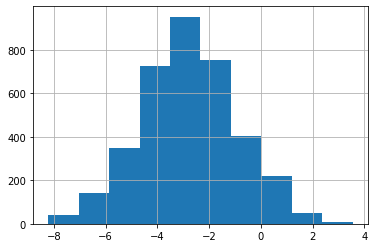

In [5]:
df.intensity.hist()

In [6]:
df['int_group'] = np.digitize(df['intensity'].values, df['intensity'].quantile(np.arange(0,1,0.1)).values) - 1
df['int_group'] = df.int_group.astype('category')

In [7]:
df.groupby('int_group').gene.count()

int_group
0    364
1    364
2    364
3    364
4    364
5    364
6    364
7    364
8    364
9    364
Name: gene, dtype: int64

### Sequence features extraction

In [8]:
# Length of the sequence
df['len_seq'] = [len(i) for i in df.loc[:,'utr_seq']]
df['len_seq_log'] = [math.log(len(i)) for i in df.loc[:,'utr_seq']]

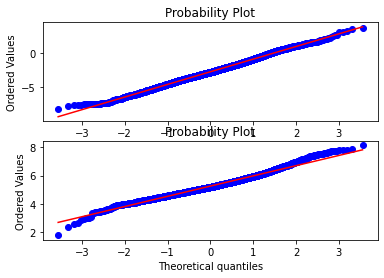

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
prob = stats.probplot(df.intensity, dist=stats.norm, plot=ax1)

ax2 = fig.add_subplot(212)
prob = stats.probplot(df.len_seq_log, dist=stats.norm, plot=ax2)


In [10]:
# AT/GC ratio
df['at_gc'] = [(i.count('A')+i.count('T'))/(i.count('G')+i.count('C')) for i in df.loc[:,'utr_seq']]

In [11]:
# Percent GC
df['pct_gc'] = [SeqUtils.GC(i) for i in df.loc[:,'utr_seq']]

In [12]:
# Molecular weight
df['molecular_w'] = [SeqUtils.molecular_weight(i) for i in df.loc[:,'utr_seq']]

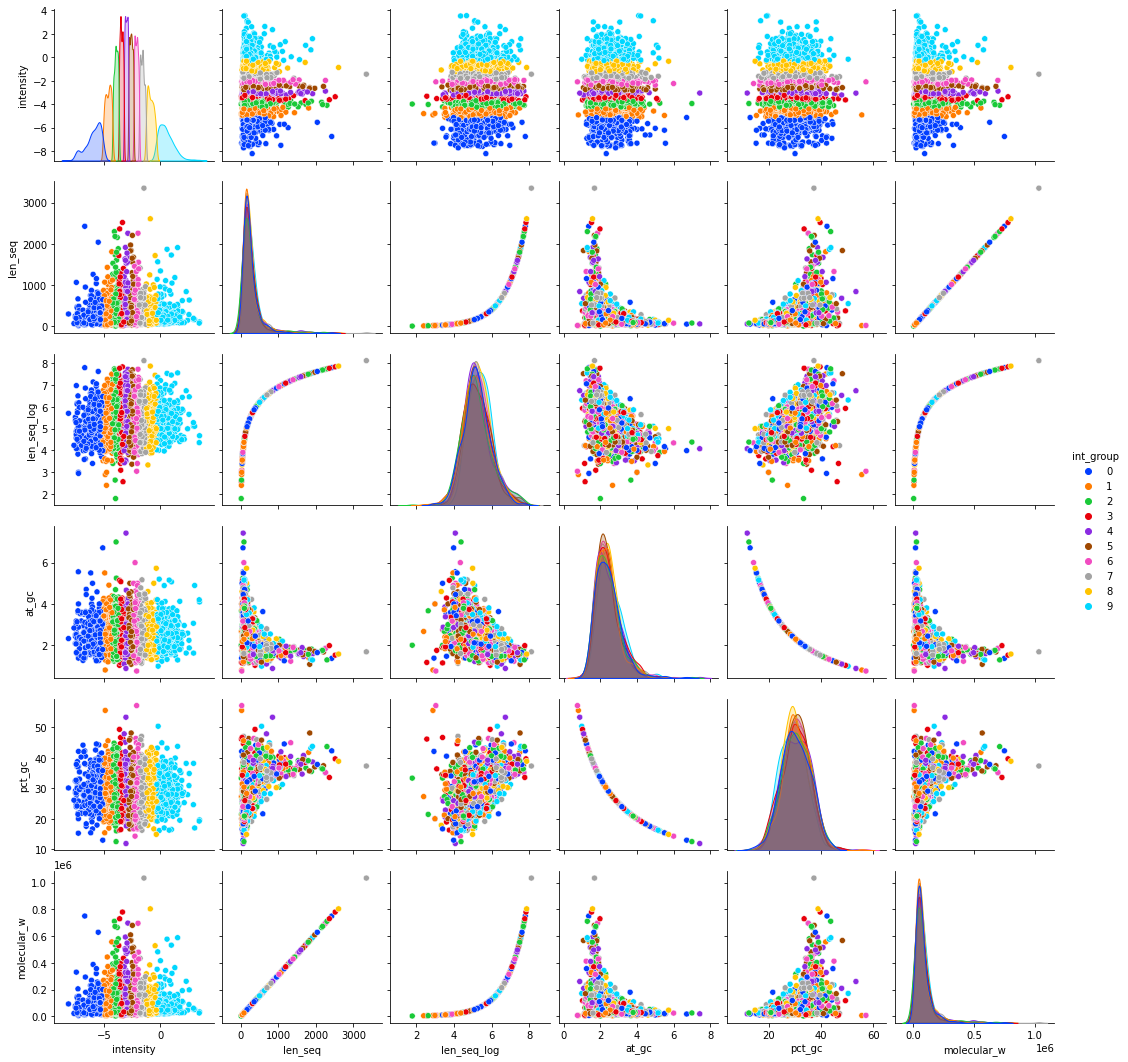

In [13]:
sns.pairplot(df, hue = 'int_group', palette = sns.color_palette('bright', 10))

In [14]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,intensity,len_seq,len_seq_log,at_gc,pct_gc,molecular_w
intensity,1.000000,0.031378,0.085637,0.048036,-0.058530,0.031166
len_seq,0.031378,1.000000,0.843832,-0.383525,0.429759,0.999992
len_seq_log,0.085637,0.843832,1.000000,-0.464112,0.474479,0.843578
at_gc,0.048036,-0.383525,-0.464112,1.000000,-0.960570,-0.383378
pct_gc,-0.058530,0.429759,0.474479,-0.960570,1.000000,0.429639
molecular_w,0.031166,0.999992,0.843578,-0.383378,0.429639,1.000000


### Per group motif discovery (TBC)

[Gibbs Sampling](https://open.oregonstate.education/appliedbioinformatics/chapter/chapter-2-sequence-motifs/).

In [15]:
df.head()

,gene,systematicName,intensity,utr_seq,int_group,len_seq,len_seq_log,at_gc,pct_gc,molecular_w
0,SSA1,YAL005C,2.477076,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...,9,147,4.990433,2.585366,27.891156,45548.2183
1,ERP2,YAL007C,-1.204719,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...,8,286,5.655992,2.445783,29.020979,88087.5535
2,FUN14,YAL008W,-0.785451,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...,8,128,4.852030,2.459459,28.906250,39623.4302
3,SPO7,YAL009W,-3.608608,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...,3,134,4.897840,2.268293,30.597015,41481.5762
4,SWC3,YAL011W,-3.443864,AGGTGTTCGGTTACTTTATTCTGCTTTAACGCCATTATGATTATAC...,3,135,4.905275,2.375000,29.629630,41519.5406


In [16]:
import os
import csv
os.makedirs('meme_input', exist_ok=True)
def write_file(x):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{x['int_group'].unique()[0]}.fasta", 'w') as out:
        out.write('\n'.join(p.values))
df.groupby('int_group').apply(write_file)

""


In [17]:
def write_inv_file(x, i):
    p = x['utr_seq'].apply(
        lambda y: f'>{id(y)}\n' + y)
    with open(f"meme_input/{i}inv.fasta", 'w') as out:
        out.write('\n'.join(p.values))
for cnt in range(10):
    write_inv_file(df[df['int_group'] != cnt], cnt)

In [18]:
from Bio.motifs import parse

In [126]:
motifs = []
motifs_s = {}
for cnt in range(10):
    with open(f"meme_output/{cnt}b.txt") as f:
        i_motifs = parse(f, 'MINIMAL')
        motifs_s[cnt] = [str(s.degenerate_consensus) for s in i_motifs][:-3]
        motifs.extend(i_motifs[:-3])

In [127]:
len(motifs)

8

In [128]:
motifs_s

{0: ['CATTAATTT', 'GTAATACCT'],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: ['ACTAATAC', 'AAGAGC', 'GAAGAW', 'TATGTACATA'],
 8: ['TATAAAAGAAAANA'],
 9: ['ATAAAAAATAANW']}

In [130]:
from tqdm.notebook import tqdm

In [131]:
def create_features(seqs, motifs):
    scores = np.zeros([len(seqs), len(motifs)])
    counts = np.zeros([len(seqs), len(motifs)])
    for s_c, seq in tqdm(enumerate(seqs)):
        for m_c, motif in enumerate(motifs):
            try:
                weights = motif.pssm
                sc = weights.calculate(seq)
                counts[s_c, m_c] = sum(sc > 0)
                scores[s_c, m_c] = np.mean(sc[sc>0])
            except:
                counts[s_c, m_c] = 0
                scores[s_c, m_c] = None
    return counts, scores
    
            
counts, scores = create_features(seqs, motifs)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in true_divide



In [132]:
columns = [str(m.degenerate_consensus) for m in motifs]
columns_scores = [c + '_score' for c in columns]
columns_tfidf = [c + '_tfidif' for c in columns]

In [133]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer().fit_transform(counts)
tfidf = tfidf.todense()

In [134]:
featDf = pd.DataFrame(np.hstack([scores, tfidf]), columns=columns_scores+columns_tfidf)

In [135]:
featDf.fillna(0, inplace=True)

In [136]:
featDf['intensity'] = df['intensity']
featDf['int_group'] = df['int_group']
df = featDf

Checking for significant difference in FI between genes with and without efficiency element.

In [137]:
p_vals = []
for e in columns_scores:
    grp0 = df.loc[df[e] == 0].intensity
    grp1 = df.loc[df[e] != 0].intensity
    f_val, p_val = stats.ttest_ind(grp0, grp1)            
    print(f"({e} size0 = {len(grp0)}, size1 = {len(grp1)}) One-way ANOVA P ={p_val}")
    p_vals.append(p_val)

(CATTAATTT_score size0 = 1010, size1 = 2630) One-way ANOVA P =0.13887420449679402
(GTAATACCT_score size0 = 537, size1 = 3103) One-way ANOVA P =4.086218031836e-07
(ACTAATAC_score size0 = 3612, size1 = 28) One-way ANOVA P =0.3355665469345178
(AAGAGC_score size0 = 143, size1 = 3497) One-way ANOVA P =0.07807220534916831
(GAAGAW_score size0 = 692, size1 = 2948) One-way ANOVA P =0.002299091467806948
(TATGTACATA_score size0 = 1322, size1 = 2318) One-way ANOVA P =0.004158906983623797
(TATAAAAGAAAANA_score size0 = 820, size1 = 2820) One-way ANOVA P =4.730281680767967e-05
(ATAAAAAATAANW_score size0 = 3116, size1 = 524) One-way ANOVA P =0.01461344077893842


In [138]:
from statsmodels.stats.multitest import fdrcorrection
q_vals = fdrcorrection(p_vals)[1]

In [139]:
sig_mots = np.array(columns_scores)[q_vals < 0.05]

In [140]:
len(sig_mots)

5

In [141]:
df['int_group'] = df['int_group'].astype(float)

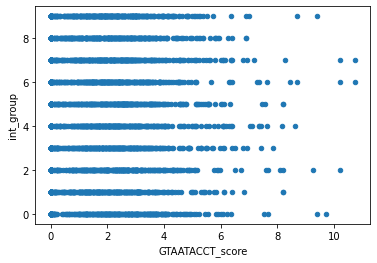

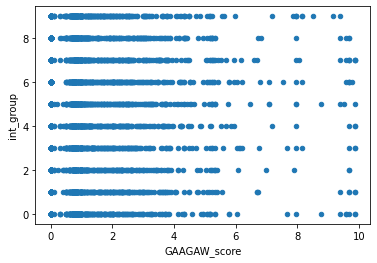

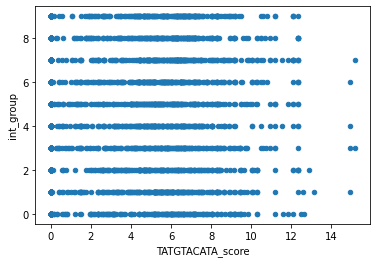

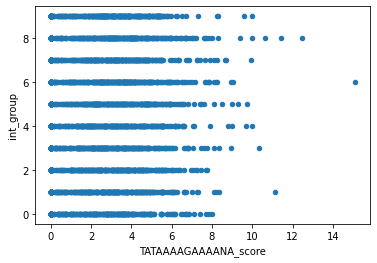

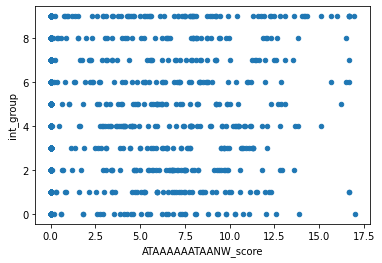

In [142]:
for sig in sig_mots:
    df[[sig,'int_group']].sort_values(sig).plot.scatter(x=sig,y='int_group')

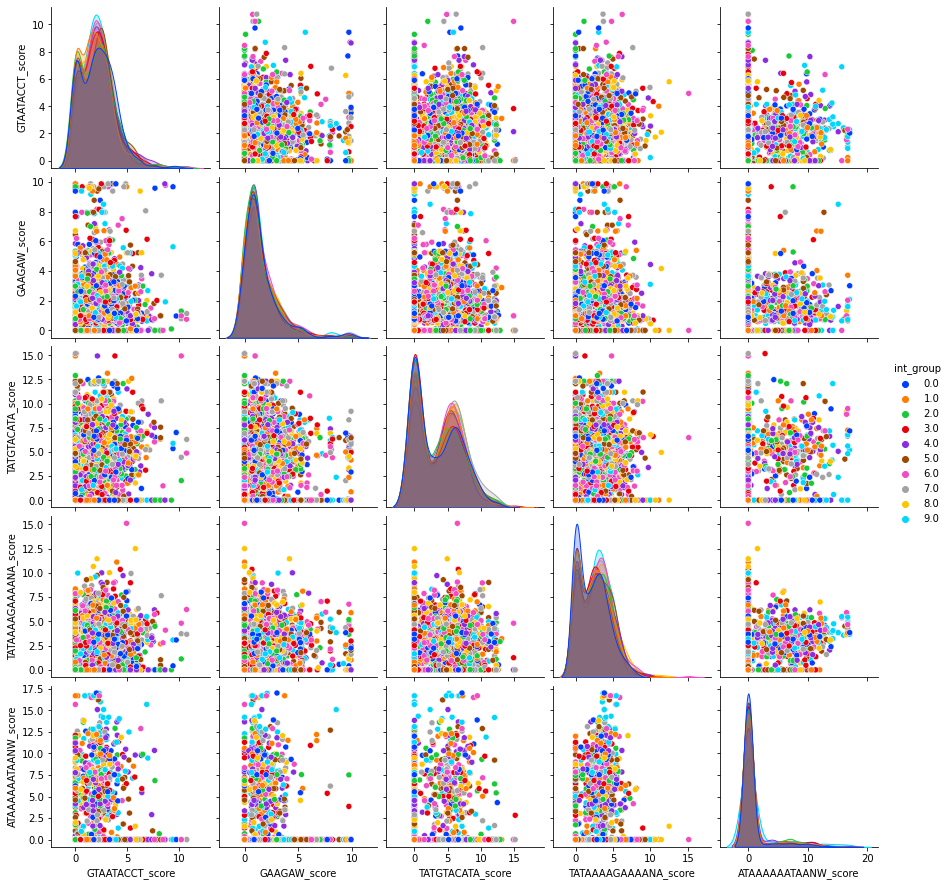

In [143]:
sns.pairplot(df[sig_mots.tolist() + ['int_group']], hue = 'int_group', palette = sns.color_palette('bright', 10))

In [144]:
df

,CATTAATTT_score,GTAATACCT_score,ACTAATAC_score,AAGAGC_score,GAAGAW_score,TATGTACATA_score,TATAAAAGAAAANA_score,ATAAAAAATAANW_score,CATTAATTT_tfidif,GTAATACCT_tfidif,ACTAATAC_tfidif,AAGAGC_tfidif,GAAGAW_tfidif,TATGTACATA_tfidif,TATAAAAGAAAANA_tfidif,ATAAAAAATAANW_tfidif,intensity,int_group
0,0.000000,0.000000,0.0,0.826487,0.723480,6.834595,3.558825,0.000000,0.000000,0.000000,0.0,0.439883,0.384066,0.767166,0.265428,0.000000,2.477076,9.0
1,3.204258,2.820573,0.0,0.318984,0.767343,1.775209,6.457604,0.000000,0.259502,0.378533,0.0,0.543238,0.395256,0.094742,0.573638,0.000000,-1.204719,8.0
2,4.426875,0.112950,0.0,0.764684,5.234659,1.775209,0.000000,0.000000,0.187345,0.163967,0.0,0.882417,0.342421,0.205194,0.000000,0.000000,-0.785451,8.0
3,0.000000,1.703969,0.0,3.812949,3.310422,1.402887,0.000000,0.000000,0.000000,0.182729,0.0,0.655590,0.572403,0.457346,0.000000,0.000000,-3.608608,3.0
4,0.000000,6.121003,0.0,0.094522,1.726247,0.000000,0.000000,0.000000,0.000000,0.823749,0.0,0.369429,0.430070,0.000000,0.000000,0.000000,-3.443864,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3635,5.402391,1.823792,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.916121,0.400901,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-4.714288,1.0
3636,1.278023,3.296499,0.0,2.309955,0.000000,0.000000,0.000000,0.000000,0.237329,0.623142,0.0,0.745231,0.000000,0.000000,0.000000,0.000000,-5.350277,0.0
3637,2.607014,1.783605,0.0,0.584940,0.886544,5.160325,2.850055,0.000000,0.326129,0.114173,0.0,0.819256,0.357651,0.142880,0.247172,0.000000,-6.448889,0.0
3638,7.125870,1.126241,0.0,0.055469,0.000000,0.000000,0.000000,0.000000,0.862081,0.377253,0.0,0.338375,0.000000,0.000000,0.000000,0.000000,-4.412007,1.0


### PCA

In [145]:
import plotly
from plotly import version
print (version)
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

<module 'plotly.version' from '/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/plotly/version.py'>


In [146]:
from sklearn.decomposition import PCA
import plotly.express as px

In [147]:
features = columns_tfidf

In [148]:
df_temp = df[features]
# df_temp = df_6mers_test.loc[:, (df_6mers.columns != 'gene') & (df_6mers.columns != 'intensity')]
# df_temp = (df_temp-df_temp.mean())/df_temp.std()
# df_temp = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
df_temp

,CATTAATTT_tfidif,GTAATACCT_tfidif,ACTAATAC_tfidif,AAGAGC_tfidif,GAAGAW_tfidif,TATGTACATA_tfidif,TATAAAAGAAAANA_tfidif,ATAAAAAATAANW_tfidif
0,0.000000,0.000000,0.0,0.439883,0.384066,0.767166,0.265428,0.000000
1,0.259502,0.378533,0.0,0.543238,0.395256,0.094742,0.573638,0.000000
2,0.187345,0.163967,0.0,0.882417,0.342421,0.205194,0.000000,0.000000
3,0.000000,0.182729,0.0,0.655590,0.572403,0.457346,0.000000,0.000000
4,0.000000,0.823749,0.0,0.369429,0.430070,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3635,0.916121,0.400901,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3636,0.237329,0.623142,0.0,0.745231,0.000000,0.000000,0.000000,0.000000
3637,0.326129,0.114173,0.0,0.819256,0.357651,0.142880,0.247172,0.000000
3638,0.862081,0.377253,0.0,0.338375,0.000000,0.000000,0.000000,0.000000


In [149]:
%matplotlib inline

In [150]:
pca = PCA(n_components = 7)
components = pca.fit_transform(df_temp)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(7),
    color=df.int_group,
    title=f'Total Explained Variance: {total_var:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [151]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

x = 0
y = 1

fig = px.scatter(components, x=x, y=y, color=df.int_group)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, x],
        y1=loadings[i, y]
    )
    fig.add_annotation(
        x=loadings[i, x],
        y=loadings[i, y],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [152]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

### Classification (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [153]:

# df_temp = pd.DataFrame(components)
df_temp = df.loc[:, features]

# df_temp = (df_temp-df_temp.mean())/df_temp.std()
df_temp

,CATTAATTT_tfidif,GTAATACCT_tfidif,ACTAATAC_tfidif,AAGAGC_tfidif,GAAGAW_tfidif,TATGTACATA_tfidif,TATAAAAGAAAANA_tfidif,ATAAAAAATAANW_tfidif
0,0.000000,0.000000,0.0,0.439883,0.384066,0.767166,0.265428,0.000000
1,0.259502,0.378533,0.0,0.543238,0.395256,0.094742,0.573638,0.000000
2,0.187345,0.163967,0.0,0.882417,0.342421,0.205194,0.000000,0.000000
3,0.000000,0.182729,0.0,0.655590,0.572403,0.457346,0.000000,0.000000
4,0.000000,0.823749,0.0,0.369429,0.430070,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3635,0.916121,0.400901,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3636,0.237329,0.623142,0.0,0.745231,0.000000,0.000000,0.000000,0.000000
3637,0.326129,0.114173,0.0,0.819256,0.357651,0.142880,0.247172,0.000000
3638,0.862081,0.377253,0.0,0.338375,0.000000,0.000000,0.000000,0.000000


In [154]:
from sklearn.model_selection import train_test_split
df_subset = df[df['int_group'].isin([0,9])]
df_subset['int_bool'] = df_subset.int_group.astype(float) >= 5
X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.int_bool, test_size=0.5,
                                                    stratify=df_subset.int_bool, random_state=123456)

<ipython-input-154-5b2ddcdb4b36>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [155]:
X_train

,CATTAATTT_tfidif,GTAATACCT_tfidif,ACTAATAC_tfidif,AAGAGC_tfidif,GAAGAW_tfidif,TATGTACATA_tfidif,TATAAAAGAAAANA_tfidif,ATAAAAAATAANW_tfidif
211,0.107425,0.188040,0.0,0.758976,0.294520,0.352980,0.407086,0.000000
2829,0.310700,0.815786,0.0,0.487810,0.000000,0.000000,0.000000,0.000000
1109,0.000000,0.097206,0.0,0.523131,0.203001,0.364941,0.736542,0.000000
2973,0.131601,0.115179,0.0,0.723163,0.240534,0.000000,0.623373,0.000000
2888,0.362531,0.211529,0.0,0.569188,0.220873,0.661785,0.114484,0.000000
...,...,...,...,...,...,...,...,...
2268,0.172580,0.604177,0.0,0.677391,0.315434,0.141767,0.163497,0.000000
2175,0.342757,0.299986,0.0,0.807212,0.000000,0.375413,0.000000,0.000000
3428,0.111324,0.194864,0.0,0.786520,0.305208,0.487719,0.000000,0.000000
1474,0.255303,0.391028,0.0,0.801670,0.291645,0.139813,0.120933,0.141469


In [156]:
y_train

211      True
2829    False
1109    False
2973     True
2888     True
        ...  
2268     True
2175    False
3428    False
1474     True
3616     True
Name: int_bool, Length: 364, dtype: bool

In [157]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



RandomForestClassifier(oob_score=True, random_state=123456)

In [158]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.486
Mean accuracy score: 0.544


<AxesSubplot:>

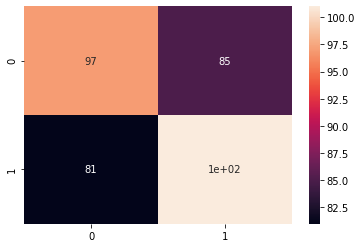

In [159]:
from sklearn.metrics import confusion_matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=range(2), index=range(2))
sns.heatmap(cm, annot=True)

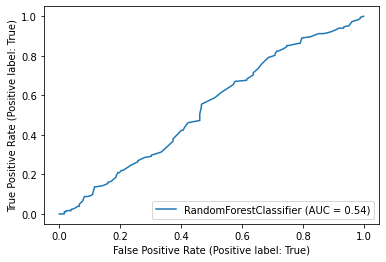

In [160]:
from sklearn.metrics import RocCurveDisplay
rf_disp = RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.show()

### Regression (RF)

[Source](https://www.blopig.com/blog/2017/07/using-random-forests-in-python-with-scikit-learn/)

In [162]:
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df_subset.loc[:,features], df_subset.intensity, train_size=0.8, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

In [163]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0)

In [164]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

Out-of-bag R-2 score estimate: -0.0791
Test data R-2 score: -0.0408
Test data Spearman correlation: 0.182
Test data Pearson correlation: 0.171


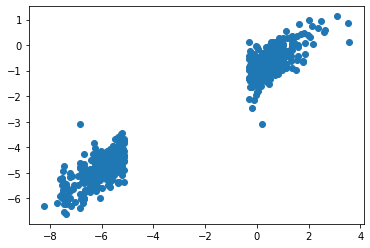

In [165]:
plt.scatter(y_train, predicted_train)

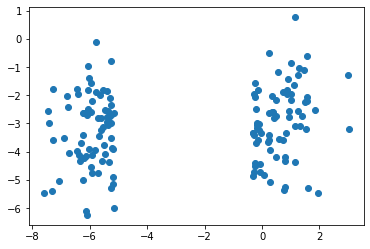

In [166]:
plt.scatter(y_test, predicted_test)

In [167]:
from umap.umap_ import UMAP

In [168]:
umap = UMAP().fit(df_temp[features])

In [169]:
import umap.plot  # pip install umap-learn[plot]

umap.plot.points(umap, labels=clusterLabels, theme="viridis")

/home/vaslem/code/kaggle/.venv/lib/python3.8/site-packages/umap/plot.py:20: UserWarning:

The umap.plot package requires extra plotting libraries to be installed.
    You can install these via pip using

    pip install umap-learn[plot]

    or via conda using

     conda install pandas matplotlib datashader bokeh holoviews colorcet scikit-image
    



ImportError: umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

<AxesSubplot:>

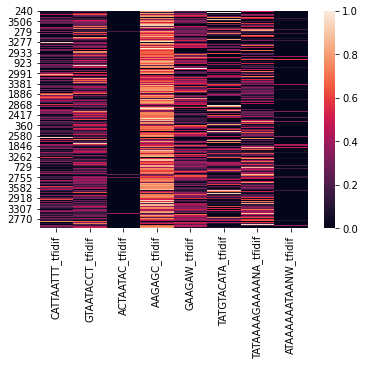

In [170]:
sns.heatmap(df.sort_values('intensity')[features])

<AxesSubplot:>

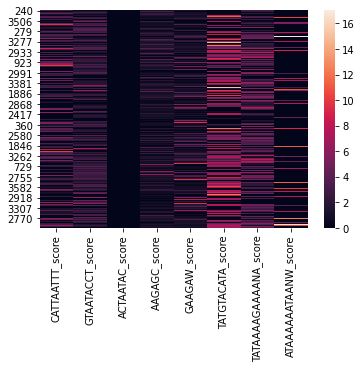

In [171]:
sns.heatmap(df.sort_values('intensity')[columns_scores])